<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/biagiominio/Remote_sensing_2021/blob/main/R_code_land_cover.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/biagiominio/Remote_sensing_2021/blob/main/R_code_land_cover.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>




# Deforestation in Mato Grosso, Brazil

An inland state of central Brazil, deep in the Amazon interior, Mato Grosso was long isolated from the outside world. A railroad, followed by highways and airplanes, eventually connected this state with other regions in the twentieth century. By the early twenty-first century, modern technology had clearly reached Mato Grosso and produced widespread change.

The Thematic Mapper on NASA’s Landsat 5 satellite captured the top image of part of Mato Grosso on August 6, 1992. The Advanced Spaceborne Thermal Emission and Reflection Radiometer (ASTER) on NASA’s Terra satellite captured the bottom image of the same area on July 28, 2006. In both of these false-color images, red indicates vegetation, and the brighter the red, the denser the vegetation. The Rio Peixoto de Azevedo appears pale blue, nearly white, in 1992, perhaps a combination of reflective sediment or sunlight glinting off the water.

The most conspicuous difference between the images is the widespread forest clearing—visible as rectangles of gray-beige that had occurred by 2006. The most intense areas of clearing appear along roadways, such as road MT-419, which runs east to west north of the river. A 2006 study found that Brazil’s mechanized agriculture increased by more than 3.6 million hectares (8.9 million acres) between 2001 and 2004, growing more than 540,000 hectares (1.3 million acres) in Mato Grosso alone. Clearing for pasture was still the leading cause of deforestation at that time, but the contribution from large agricultural clearings, such as for soy plantations, was increasing.

<table>
  <tr>
     <td>Mato Grosso on August 6, 1992</td>
     <td>Mato Grosso on July 28, 2006</td>
  </tr>
  <tr>
    <td><img src="https://eoimages.gsfc.nasa.gov/images/imagerecords/35000/35891/matogrosso_l5_1992219_lrg.jpg" width=500</td>
    <td><img src="https://eoimages.gsfc.nasa.gov/images/imagerecords/35000/35891/matogrosso_ast_2006209_lrg.jpg" width=500</td>
  </tr>
</table>

<font size="2"> [*NASA images*](https://earthobservatory.nasa.gov/images/35891/deforestation-in-mato-grosso-brazil) *created by Jesse Allen, using Landsat data provided by the United States Geological Survey and ASTER data provided courtesy of NASA/GSFC/METI/ERSDAC/JAROS, and U.S./Japan ASTER Science Team. Caption by Michon Scott.*</font> 

In [8]:
mato_grosso_1992_url <- "https://eoimages.gsfc.nasa.gov/images/imagerecords/35000/35891/matogrosso_l5_1992219_lrg.jpg"
mato_grosso_2006_url <- "https://eoimages.gsfc.nasa.gov/images/imagerecords/35000/35891/matogrosso_ast_2006209_lrg.jpg"

The [download.file](https://www.rdocumentation.org/packages/utils/versions/3.6.2/topics/download.file) function can be used to download a file from the Internet. 
```
download.file(url, destfile)
```
In the function the `url` argument sets the resource to be downloaded and the `destfile` a character string with which the downloaded file is named.

In [9]:
download.file(mato_grosso_1992_url, "Mato_Grosso_1992.jpg")
download.file(mato_grosso_2006_url, "Mato_Grosso_2006.jpg")

## Install R packages
The [install.packages](https://www.rdocumentation.org/packages/utils/versions/3.6.2/topics/install.packages) function is used to download and install packages from CRAN-like repositories.
To install multiple packages at the same time, you define a vector that contains the names of the packages to be installed.

The [raster](https://www.rdocumentation.org/packages/raster/versions/3.4-10) package defines classes and methods for spatial raster data access and manipulation. 

[RStoolbox](https://www.rdocumentation.org/packages/RStoolbox/versions/0.2.6) is an package providing a wide range of tools for your every-day remote sensing processing needs. The available tool-set covers many aspects for remote sensing image processing and analysis such as calculating spectral indices, principal component transformation, unsupervised and supervised classification or fractional cover analyses.

The [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.3.3) package is a system for declaratively creating graphics. 
It provides a more programmatic interface for specifying what variables to plot, how they are displayed, and general visual properties. 

While the [gridExtra](https://www.rdocumentation.org/packages/gridExtra/versions/2.3/topics/gridExtra-package) package provides a number of user-level functions to work with "grid" graphics, notably to arrange multiple grid-based plots on a page, and draw tables.

In [ ]:
packages <- c("raster", "RStoolbox", "ggplot2", "gridExtra")
install.packages(packages)

The [library](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/library) function is used to load previously installed packages.
Using the [lapply](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/lapply) function we simultaneously apply the `library()` function to all elements of the vector containing the packages.



In [ ]:
lapply(packages , library, character.only = TRUE)

## Reading spatial data
To read and view a multilevel object it is common to use the [brick](https://www.rdocumentation.org/packages/raster/versions/3.4-5/topics/brick) function (RasterBrick object). 

Explore the properties of the `mato_grosso_1992` and `mato_grosso_2006` object.



In [ ]:
mato_grosso_1992 <- brick( "Mato_Grosso_1992.jpg")
mato_grosso_2006 <- brick( "Mato_Grosso_2006.jpg")

The brick object has three bands that correspond to the following portions of the electromagnetic spectrum:

$\mathsf{B1}$ = Near Infrared; 
$\mathsf{B2}$ = Red;
$\mathsf{B3}$ = Green;

Change the names of a raster object using the [names](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/names) function.


In [11]:
names(mato_grosso_1992) <- c("nir", "red", "green")
names(mato_grosso_2006) <- c("nir", "red", "green")
mato_grosso_1992

class      : RasterBrick 
dimensions : 1500, 1200, 1800000, 3  (nrow, ncol, ncell, nlayers)
resolution : 1, 1  (x, y)
extent     : 0, 1200, 0, 1500  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : Mato_Grosso_1992.jpg 
names      : nir, red, green 
min values :   0,   0,     0 
max values : 255, 255,   255 


The two images have a different extension and this could be a problem when comparing pixels or intersections. 

Let's see how to make the extension of the two images equal.

In [ ]:
mato_grosso_2006@extent <- mato_grosso_1992@extent

Now the `mato_grosso_1992` image has the same extension as the `mato_grosso_2006` object, but has a different resolution and dimension.

To work around this problem, reduce the resolution of the `mato_grosso_2006` image by enlarging the pixels until they are the same size as the `mato_grosso_1992` object.
To create a new RasterBrick object with a lower resolution use the [aggregate](https://www.rdocumentation.org/packages/raster/versions/3.4-10/topics/aggregate) function of the `raster` package.

In [13]:
mato_grosso_2006.res <- aggregate(mato_grosso_2006, fun=mean, fact=2)
mato_grosso_2006.res

class      : RasterBrick 
dimensions : 1500, 1200, 1800000, 3  (nrow, ncol, ncell, nlayers)
resolution : 1, 1  (x, y)
extent     : 0, 1200, 0, 1500  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : nir, red, green 
min values :   0,   0,     0 
max values : 255, 255,   255 


### Visualization of spatial data
Several generic functions have been implemented for "raster" objects to create maps and other plot types. For example, use [plot](https://www.rdocumentation.org/packages/raster/versions/3.4-5/topics/plot) function to create a map of a raster object.
In addition, individual bands can be combined into a single image by assigning individual layers or bands to one of the three color channels (red, green and blue). 
The [plotRGB](https://www.rdocumentation.org/packages/raster/versions/3.4-5/topics/plotRGB) function can be used to make "true (or false) color images" from multi-band satellite images.

Use the [par](https://www.rdocumentation.org/packages/graphics/versions/3.6.2/topics/par) function to compare the images of Mato Grosso over the two different years.
Export the image using the [pdf](https://www.rdocumentation.org/packages/grDevices/versions/3.6.2/topics/pdf) function to enlarge it better and view the results.

N.B. always use the `dev.off()` function to manage the correct closing and loading of the graphics device.


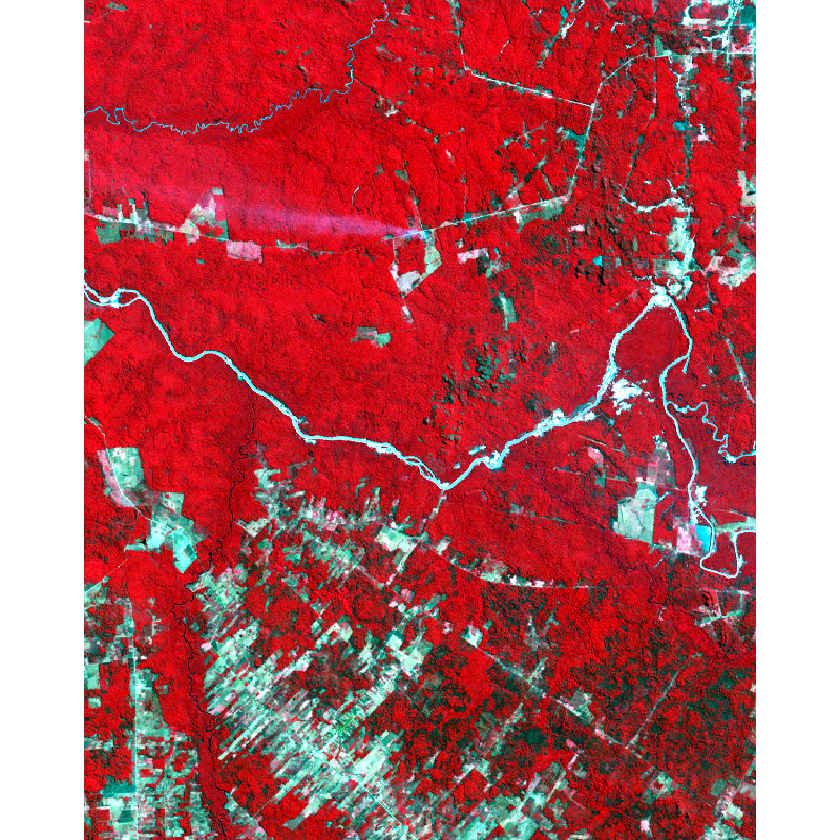

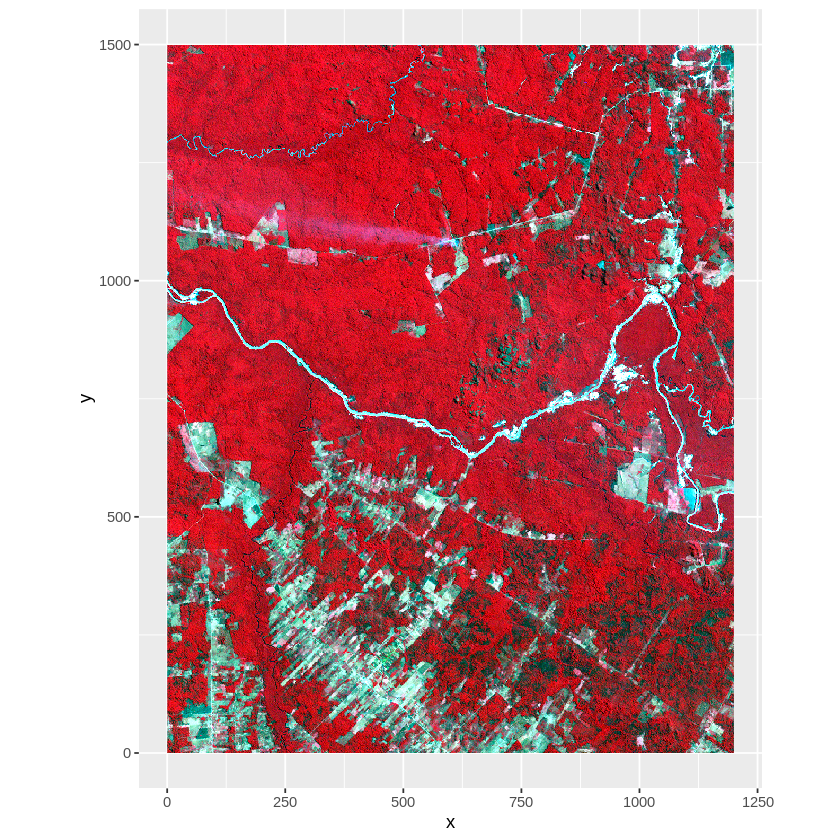

In [14]:
par(mfrow=c(1,2))
plotRGB(mato_grosso_1992, r=1, g=2, b=3, stretch="lin")
plotRGB(mato_grosso_2006.res, r=1, g=2, b=3, stretch="lin")

In [ ]:
# multiframe with ggplot2 and gridExtra
p1 <- ggRGB(mato_grosso_1992, r=1, g=2, b=3, stretch="lin")
p2 <- ggRGB(mato_grosso_2006.res, r=1, g=2, b=3, stretch="lin")
grid.arrange(p1, p2, nrow=2)

### Unsupervised clustering
[K-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering is one of the simplest and popular unsupervised learning algorithms.
Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labeled, outcomes.

The `RStoolbox` package provides the [unsuperClass](https://www.rdocumentation.org/packages/RStoolbox/versions/0.2.6/topics/unsuperClass) function which allows you to apply the k-means algorithm to any Raster Object.

Furthermore, by setting the same seed with the [set.seed](https://www.rdocumentation.org/packages/simEd/versions/2.0.0/topics/set.seed) function (a random number generator) we always select the same initial pixels during the construction phase of the n-clusters in order to always show the same output.


In [ ]:
# unsupervised classification
set.seed(1234)
mato_grosso_1992.class <- RStoolbox::unsuperClass(mato_grosso_1992, nClasses=2)
plot(mato_grosso_1992.class$map)

In [ ]:
set.seed(1234)
mato_grosso_2006.res.class <- RStoolbox::unsuperClass(mato_grosso_2006.res, nClasses=2)
plot(mato_grosso_2006.res.class$map)

In [ ]:
# frequencies
freq(d1c$map)

In [ ]:
s1 <- 306583 + 34709
prop1 <- freq(d1c$map) / s1
# prop forest: 0.8983012
# prop agriculture: 0.1016988
s2 <- 342726
prop2 <- freq(d2c$map) / s2
# prop forest: 0.5206958
# prop agriculture: 0.4793042

In [ ]:
# build a dataframe
cover <- c("Forest","Agriculture")
percent_1992 <- c(89.83, 10.16)
percent_2006 <- c(52.06, 47.93)
percentages <- data.frame(cover, percent_1992, percent_2006)
percentages
## cover percent_1992 percent_2006
## 1 Forest 89.83 52.06
## 2 Agriculture 10.16 47.93

In [ ]:
# let's plot them!
ggplot(percentages, aes(x=cover, y=percent_1992, color=cover)) + geom_bar(stat="identity", fill="white")
ggplot(percentages, aes(x=cover, y=percent_2006, color=cover)) + geom_bar(stat="identity", fill="white")
p1 <- ggplot(percentages, aes(x=cover, y=percent_1992, color=cover)) + geom_bar(stat="identity", fill="white")
p2 <- ggplot(percentages, aes(x=cover, y=percent_2006, color=cover)) + geom_bar(stat="identity", fill="white")
grid.arrange(p1, p2, nrow=1)